# Linac simulation analysis

In [22]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
import yaml
from ipywidgets import interact
from ipywidgets import widgets
from omegaconf import OmegaConf
from omegaconf import DictConfig
from pprint import pprint

from analysis import get_input_dir

In [23]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["cycle"] = "538"
pplt.rc["grid"] = False
pplt.rc["figure.facecolor"] = "white"

## Setup

In [24]:
timestamp = None  # None selects latest
script_name = "sim"

input_dir = get_input_dir(timestamp, script_name)
print("input_dir = ", input_dir)

input_dir =  outputs/sim/240605124826


In [25]:
cfg_path = os.path.join(input_dir, "config/config.yaml")
cfg = yaml.safe_load(open(cfg_path, "r"))
cfg = DictConfig(cfg)

print("config:")
print(OmegaConf.to_yaml(cfg))

config:
timestamp: ${now:%y%m%d%H%M%S}
bunch:
  energy: 0.0025
  mass: 0.939294
  charge: -1.0
  current: 0.038
  size: 100000
  path: null
  dist: waterbag
  alpha_x: -1.962
  alpha_y: 1.7681
  alpha_z: -0.0196
  beta_x: 0.1831
  beta_y: 0.162
  beta_z: 0.5844
  eps_x: 2.1e-07
  eps_y: 2.1e-07
  eps_z: 2.4153e-07
lattice:
  xml: null
  seq_start: MEBT
  seq_stop: SCLHigh
  max_drift: 0.01
  rf_freq: 402500000.0
  sc: 0
  rf: false
sc:
  solver: fft
  gridx: 64
  gridy: 64
  gridz: 64
  path_length_min: 0.01
  n_ellipsoids: 5
start: 0.0
stop: null
stride: 0.01
stride_write: 50.0
stride_plot: null



In [26]:
cycle_colors = pplt.Cycle(pplt.rc["cycle"]).by_key()["color"]

## Scalars

In [27]:
history = pd.read_csv(os.path.join(input_dir, "history.dat"))
history.head()

,position,node,n_parts,gamma,beta,energy,x_rms,y_rms,z_rms,z_rms_deg,...,cov_1-4,cov_2-4,cov_3-4,cov_4-4,cov_0-5,cov_1-5,cov_2-5,cov_3-5,cov_4-5,cov_5-
0,0.0000,MEBT_START,100000,1.002662,0.072815,0.0025,0.000725,0.000683,0.001389,9.221718,...,-5.772852e-08,-2.496874e-09,3.057301e-08,0.000002,-2.116660e-11,-1.830494e-10,-3.271339e-12,-7.441145e-11,2.938523e-10,1.415746e-10
1,0.0195,MEBT:MEBT_START:2:drift,100000,1.002662,0.072815,0.0025,0.000880,0.000544,0.001391,9.232264,...,-5.845948e-08,-1.915565e-09,3.028652e-08,0.000002,-2.473841e-11,-1.830494e-10,-4.716622e-12,-7.441145e-11,8.439324e-10,1.415746e-10
2,0.0390,MEBT:MEBT_START:4:drift,100000,1.002662,0.072815,0.0025,0.001040,0.000425,0.001394,9.252988,...,-5.919045e-08,-1.345388e-09,3.000003e-08,0.000002,-2.831023e-11,-1.830494e-10,-6.161906e-12,-7.441145e-11,1.394012e-09,1.415746e-10
3,0.0585,MEBT:MEBT_START:6:drift,100000,1.002662,0.072815,0.0025,0.001203,0.000348,0.001399,9.283820,...,-5.992142e-08,-7.863420e-10,2.971354e-08,0.000002,-3.188205e-11,-1.830494e-10,-7.607190e-12,-7.441145e-11,1.944093e-09,1.415746e-10
4,0.0780,MEBT:MEBT_START:8:drift,100000,1.002662,0.072815,0.0025,0.001368,0.000343,0.001405,9.324661,...,-6.065238e-08,-2.384282e-10,2.942705e-08,0.000002,-3.545387e-11,-1.830494e-10,-9.052474e-12,-7.441145e-11,2.494173e-09,1.415746e-10


In [28]:
print("history keys:")
pprint(list(history.keys()))

history keys:
['position',
 'node',
 'n_parts',
 'gamma',
 'beta',
 'energy',
 'x_rms',
 'y_rms',
 'z_rms',
 'z_rms_deg',
 'z_to_phase_coeff',
 'xp_rms',
 'yp_rms',
 'de_rms',
 'x_min',
 'x_max',
 'y_min',
 'y_max',
 'z_min',
 'z_max',
 'eps_x',
 'eps_y',
 'eps_z',
 'eps_1',
 'eps_2',
 'eps_xy',
 'eps_xz',
 'eps_yz',
 'eps_xyz',
 'mean_0',
 'mean_1',
 'mean_2',
 'mean_3',
 'mean_4',
 'mean_5',
 'cov_0-0',
 'cov_0-1',
 'cov_1-1',
 'cov_0-2',
 'cov_1-2',
 'cov_2-2',
 'cov_0-3',
 'cov_1-3',
 'cov_2-3',
 'cov_3-3',
 'cov_0-4',
 'cov_1-4',
 'cov_2-4',
 'cov_3-4',
 'cov_4-4',
 'cov_0-5',
 'cov_1-5',
 'cov_2-5',
 'cov_3-5',
 'cov_4-5',
 'cov_5-']


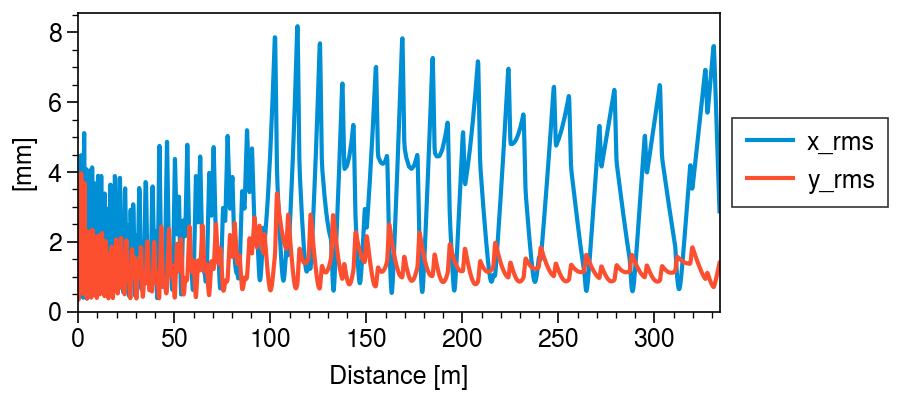

In [29]:
fig, ax = pplt.subplots(figsize=(4.5, 2.0))
for key in ["x_rms", "y_rms"]:
    ax.plot(history["position"].values, history[key].values * 1000.0, label=key)
ax.legend(loc="r", ncols=1)
ax.format(xlabel="Distance [m]", ylabel="[mm]", ymin=0.0)
plt.show()

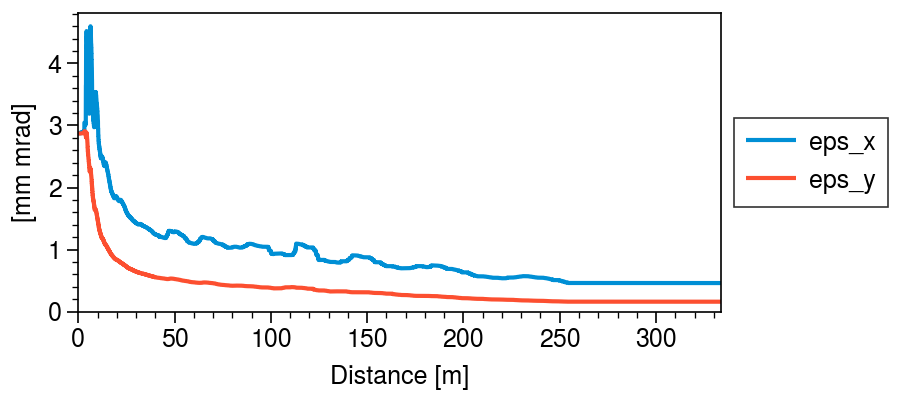

In [30]:
fig, ax = pplt.subplots(figsize=(4.5, 2.0))
for key in ["eps_x", "eps_y"]:
    ax.plot(history["position"].values, history[key].values * 1.00e+06, label=key)
ax.legend(loc="r", ncols=1)
ax.format(xlabel="Distance [m]", ylabel="[mm mrad]", ymin=0.0)
plt.show()

## Phase space distribution

In [31]:
bunch_filenames = os.listdir(input_dir)
bunch_filenames = sorted(bunch_filenames)
bunch_filenames = [f for f in bunch_filenames if f.startswith("bunch")]
bunch_filenames = [os.path.join(input_dir, f) for f in bunch_filenames]

bunches = []
for filename in bunch_filenames:
    X = np.loadtxt(filename, comments="%", usecols=range(6))
    X[:, 0] *= 1000.0  # x [m] -> [mm]
    X[:, 1] *= 1000.0  # x' [rad] -> [mrad]
    X[:, 2] *= 1000.0  # y [m] -> [mm]
    X[:, 3] *= 1000.0  # y' [rad] -> [mrad]
    X[:, 4] *= 1000.0  # z [m] -> [mm]
    X[:, 5] *= 1000.0  # dE [GeV] -> [MeV]
    bunches.append(X)

In [36]:
dims = ["x", "xp", "y", "yp", "z", "dE"]
units = ["mm", "mrad", "mm", "mrad", "mm", "MeV"]
labels = [f"{dim} [{unit}]" for dim, unit in zip(dims, units)]


limits = [
    ps.points.limits(X, zero_center=True, share=[(0, 2), (1, 3)], pad=0.25, rms=3.0)
    for X in bunches
]
limits = psv.combine_limits(limits)

### Interactive 2D projections

In [37]:
@interact(
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    index=widgets.IntSlider(min=0, max=(len(bunches) - 1), value=0),
    bins=widgets.IntSlider(min=32, max=128, value=64),
    log=False,
)
def update(dim1: str, dim2: str, index: int, bins: int, log: bool):
    if dim1 == dim2:
        return

    axis = [dims.index(dim) for dim in [dim1, dim2]]
    axis = tuple(axis)
    
    X = bunches[index]

    rho, edges = np.histogramdd(X[:, axis], bins=bins, range=[limits[axis[0]], limits[axis[1]]])
    offset = 1.0
    rho = rho + offset

    fig, ax = pplt.subplots()
    ax.pcolormesh(edges[0], edges[1], rho.T, norm=("log" if log else None))
    ax.format(xlabel=labels[axis[0]], ylabel=labels[axis[1]])
    ax.format(title=f"")

    paxs = [ax.panel_axes(loc) for loc in ["top", "right"]]
    for pax in paxs:
        pax.format(xspineloc="bottom", yspineloc="left")

    rho_x, edges_x = np.histogram(X[:, axis[0]], range=limits[axis[0]], bins=bins, density=False)
    rho_y, edges_y = np.histogram(X[:, axis[1]], range=limits[axis[1]], bins=bins, density=False)

    offset = 1.0
    rho_x = rho_x + offset
    rho_y = rho_y + offset

    kws = dict(color="black", lw=1.25)
    paxs[0].stairs(rho_x, edges_x, **kws)
    paxs[1].stairs(rho_y, edges_y, orientation="horizontal", **kws)
    if log:
        paxs[0].format(yscale="log")
        paxs[1].format(xscale="log")
    plt.show()

interactive(children=(Dropdown(description='dim1', options=('x', 'xp', 'y', 'yp', 'z', 'dE'), value='x'), Drop…

### Interactive corner

In [38]:
@interact(
    ndim=widgets.BoundedIntText(min=4, max=6, value=6),
    index=widgets.IntSlider(min=0, max=(len(bunches) - 1), value=0),
    bins=widgets.IntSlider(min=32, max=128, value=42),
    ellipse=False,
)
def update(ndim: int, index: int, bins: int, ellipse: bool):    
    X = bunches[index][:, :ndim]
    
    grid = psv.CornerGrid(ndim, diag_shrink=0.85)
    grid.plot_points(
        X,
        bins=bins,
        limits=limits,
        mask=False,
        rms_ellipse=ellipse,
        rms_ellipse_kws=dict(level=2.0, color="white"),
    )
    grid.set_labels(labels)
    grid.axs.format(suptitle=f"")
    plt.show()

interactive(children=(BoundedIntText(value=6, description='ndim', max=6, min=4), IntSlider(value=0, descriptio…